# Jiboa Case Study

This code is prepared to Run the distributed model for jiboa rover in El Salvador
wher the catchment is consisted os a ustream lake and a volcanic area
-   you have to make the root directory to the examples folder to enable the code
    from reading input files

# 1-Download Data
For the data of this case study you have to download this folder [Jiboa Data](https://drive.google.com/drive/folders/1yy6xWwx8Ucc-O72FgVxsuvJBdk3u0sVa?usp=sharing) from Google Drive and set it as the working directory instead of the Path defined in the next cell

# 2-Import modules

- please change the Path to the directory where you stored the case study data

In [1]:
import os


root = "E:\case studies\El Salvador"
os.chdir(root)

#libraries
import numpy as np
import datetime as dt

# HAPI modules
from Hapi.run import Run
from Hapi.catchment import Catchment, Lake
import Hapi.rrm.hbv as HBV
import Hapi.rrm.hbv_lake as HBVLake
import Hapi.sm.performancecriteria as Pf

# 3-Meteorological Data

- For Jiboa case study Hapi model was built for different spatial resolution (4km, 2km, 1km, and 500m )
- in the following cell you have to choose the resolution you want to use to run the model

In [2]:
res = 4000

In [3]:
# the beginning of the simulation of the calibration data
PrecPath = "inputs/Hapi/meteodata/" + str(res) + "/calib/prec_clipped"
Evap_Path = "inputs/Hapi/meteodata/" + str(res) + "/calib/evap_clipped"
TempPath = "inputs/Hapi/meteodata/" + str(res) + "/calib/temp_clipped"
FlowAccPath = "inputs/Hapi/GIS/" + str(res) + "_matched/acc" + str(res) + ".tif"
FlowDPath = "inputs/Hapi/GIS/" + str(res) + "_matched/fd" + str(res) + ".tif"
ParPath = "inputs/Hapi/meteodata/" + str(res) + "/parameters/"
# Lake
LakeMeteoPath = "inputs/Hapi/meteodata/lakedata.csv"
LakeParametersPath = "inputs/Hapi/meteodata/" + str(res) + "/Lakeparameters.txt"
GaugesPath = "inputs/Hapi/meteodata/Gauges/"
SaveTo = "results/"

# 4-Distributed Model Object

In [4]:
AreaCoeff = 227.31
InitialCond = np.loadtxt("inputs/Hapi/meteodata/Initia-jiboa.txt", usecols=0).tolist()
Snow = 0

start_date = '2012-06-14 19:00:00'
# Edate = '2014-11-17 00:00:00'
end_date = '2013-12-23 00:00:00'
name = "Jiboa"
Jiboa = Catchment(name, start_date, end_date, SpatialResolution="Distributed",
                  TemporalResolution="Hourly", fmt='%Y-%m-%d %H:%M:%S')
Jiboa.readRainfall(PrecPath)
Jiboa.readTemperature(TempPath)
Jiboa.readET(Evap_Path)
Jiboa.readFlowAcc(FlowAccPath)
Jiboa.readFlowDir(FlowDPath)
Jiboa.readParameters(ParPath, Snow)

Jiboa.readLumpedModel(HBV, AreaCoeff, InitialCond)

2022-03-19 23:32:59.351 | DEBUG    | catchment:readRainfall:200 - Rainfall data are read successfully
2022-03-19 23:33:05.199 | DEBUG    | catchment:readTemperature:253 - Temperature data are read successfully
2022-03-19 23:33:12.814 | DEBUG    | catchment:readET:295 - Potential Evapotranspiration data are read successfully
2022-03-19 23:33:12.846 | DEBUG    | catchment:readFlowAcc:387 - Flow Accmulation input is read successfully
2022-03-19 23:33:12.846 | DEBUG    | catchment:readFlowDir:441 - Flow Direction input is read successfully
2022-03-19 23:33:12.877 | DEBUG    | catchment:readParameters:624 - Parameters are read successfully
2022-03-19 23:33:12.877 | DEBUG    | catchment:readLumpedModel:678 - Lumped model is read successfully


# 5-Lake Object

For the Lake the following data is required 
- lake meteorological data
    mean rainfall, mean temperature, and mean evapotranspiration for the whole lake.
- connected cell to the distributed model :
    ([row ,column] unfortunately for now you have to provide the cell indices however in future versions this requiremtn will be replaced by the coordinates of the lake outlet).
- Stage-Discharge rating curve :
    so simulate the lake Hapi uses volume vs outflow ralationship to calculate the outflow from the lake, the internal lake sub-routine calculates the volume change for each time 
    step and using the curve the outflow can be obtained.

In [5]:
# where the lake discharges its flow (give the indices of the cell)
if res == 4000:
    OutflowCell = [2, 1]  # 4km
elif res == 2000:
    OutflowCell = [4, 2]  # 2km
elif res == 1000:
    OutflowCell = [10, 4]  # 1km
elif res == 500:
    OutflowCell = [19, 10]  # 500m

start_date = '2012.06.14 19:00:00'
# Edate = '2014.11.17 00:00:00'
end_date = '2013.12.23 00:00:00'

JiboaLake = Lake(start=start_date, end=end_date, fmt='%Y.%m.%d %H:%M:%S',
                 TemporalResolution="Hourly", Split=True)

JiboaLake.readMeteoData(LakeMeteoPath, fmt='%d.%m.%Y %H:%M')
JiboaLake.readParameters(LakeParametersPath)

StageDischargeCurve = np.loadtxt("inputs/Hapi/meteodata/curve.txt")
LakeInitCond = np.loadtxt("inputs/Hapi/meteodata/Initia-lake.txt", usecols=0).tolist()
LakeCatArea = 133.98
LakeArea = 70.64
Snow = 0
JiboaLake.readLumpedModel(HBVLake, LakeCatArea, LakeArea, LakeInitCond,
                          OutflowCell, StageDischargeCurve, Snow)

2022-03-19 23:33:53.060 | DEBUG    | catchment:readMeteoData:1584 - Lake Meteo data are read successfully
2022-03-19 23:33:53.060 | DEBUG    | catchment:readParameters:1603 - Lake Parameters are read successfully
2022-03-19 23:33:53.060 | DEBUG    | catchment:readLumpedModel:1668 - Lumped model is read successfully


# 6-Gauges

In [6]:
Date1 = '14.06.2012 19:00'
Date2 = '23.12.2013 00:00'
Jiboa.readGaugeTable(GaugesPath + "GaugesTable.csv", FlowAccPath)
Jiboa.readDischargeGauges(GaugesPath, column='id', fmt='%d.%m.%Y %H:%M',
                          Split=True, Date1=Date1, Date2=Date2)

2022-03-19 23:33:58.759 | DEBUG    | catchment:readGaugeTable:773 - Gauge Table is read successfully
2022-03-19 23:33:59.040 | DEBUG    | catchment:readDischargeGauges:867 - Gauges data are read successfully


# 7-Run the model

In [7]:
Run.runHAPIwithLake(Jiboa, JiboaLake)

Model Run has finished


## 8-Evaluate model performance

In [8]:
Jiboa.extractDischarge(OnlyOutlet=True)

for i in range(len(Jiboa.GaugesTable)):
    gaugeid = Jiboa.GaugesTable.loc[i, 'id']
    print("----------------------------------")
    print("Gauge - " + str(gaugeid))
    print("RMSE= " + str(round(Jiboa.Metrics.loc['RMSE', gaugeid], 2)))
    print("NSE= " + str(round(Jiboa.Metrics.loc['NSE', gaugeid], 2)))
    print("NSEhf= " + str(round(Jiboa.Metrics.loc['NSEhf', gaugeid], 2)))
    print("KGE= " + str(round(Jiboa.Metrics.loc['KGE', gaugeid], 2)))
    print("WB= " + str(round(Jiboa.Metrics.loc['WB', gaugeid], 2)))
    print("Pearson CC= " + str(round(Jiboa.Metrics.loc['Pearson-CC', gaugeid], 2)))
    print("R2 = " + str(round(Jiboa.Metrics.loc['R2', gaugeid], 2)))

----------------------------------
Gauge - 1
RMSE= 1.93
NSE= 0.48
NSEhf= 0.44
KGE= 0.54
WB= 72.44
Pearson CC= 0.62
R2 = 0.48


In [9]:
Qobs = Jiboa.QGauges[Jiboa.GaugesTable.loc[0, 'id']]

gaugeid = Jiboa.GaugesTable.loc[0, 'id']

WS = {}
WS['type'] = 1
WS['N'] = 3
ModelMetrics = dict()
ModelMetrics['Calib_RMSEHF'] = round(Pf.RMSEHF(Qobs, Jiboa.Qsim[gaugeid], WS['type'], WS['N'], 0.75), 3)
ModelMetrics['Calib_RMSELF'] = round(Pf.RMSELF(Qobs, Jiboa.Qsim[gaugeid], WS['type'], WS['N'], 0.75), 3)
ModelMetrics['Calib_NSEHf'] = round(Pf.NSE(Qobs, Jiboa.Qsim[gaugeid]), 3)
ModelMetrics['Calib_NSELf'] = round(Pf.NSE(np.log(Qobs), np.log(Jiboa.Qsim[gaugeid])), 3)
ModelMetrics['Calib_RMSE'] = round(Pf.RMSE(Qobs, Jiboa.Qsim[gaugeid]), 3)
ModelMetrics['Calib_KGE'] = round(Pf.KGE(Qobs, Jiboa.Qsim[gaugeid]), 3)
ModelMetrics['Calib_WB'] = round(Pf.WB(Qobs, Jiboa.Qsim[gaugeid]), 3)

print(ModelMetrics)

{'Calib_RMSEHF': 0.681, 'Calib_RMSELF': 1.143, 'Calib_NSEHf': 0.478, 'Calib_NSELf': -0.853, 'Calib_RMSE': 1.93, 'Calib_KGE': 0.542, 'Calib_WB': 72.445}


# 9-Plot Hydrograph

2022-03-19 23:34:29.223 | DEBUG    | catchment:plotHydrograph:1142 - ----------------------------------
2022-03-19 23:34:29.223 | DEBUG    | catchment:plotHydrograph:1143 - Gauge - 1
2022-03-19 23:34:29.223 | DEBUG    | catchment:plotHydrograph:1144 - RMSE= 1.93
2022-03-19 23:34:29.223 | DEBUG    | catchment:plotHydrograph:1145 - NSE= 0.48
2022-03-19 23:34:29.223 | DEBUG    | catchment:plotHydrograph:1146 - NSEhf= 0.44
2022-03-19 23:34:29.223 | DEBUG    | catchment:plotHydrograph:1147 - KGE= 0.54
2022-03-19 23:34:29.223 | DEBUG    | catchment:plotHydrograph:1148 - WB= 72.44
2022-03-19 23:34:29.223 | DEBUG    | catchment:plotHydrograph:1149 - Pearson-CC= 0.62
2022-03-19 23:34:29.223 | DEBUG    | catchment:plotHydrograph:1152 - R2= 0.48


(<Figure size 432x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Gauge - Station 1'}, xlabel='Time', ylabel='Discharge m3/s'>)

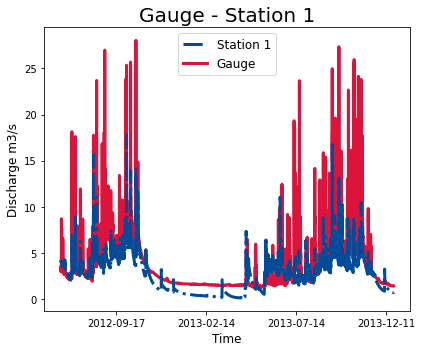

In [10]:
gaugei = 0
plotstart = "2012-06-16"
plotend = "2013-12-23"

Jiboa.plotHydrograph(plotstart, plotend, gaugei)

# 10-Animate distributed results

- To animate the distributed results you can use the `plotDistributedResults` method 
```
=============================================================================
plotDistributedResults(StartDate, EndDate, fmt="%Y-%m-%d", Option = 1, Gauges=False, TicksSpacing = 2, Figsize=(8,8), PlotNumbers=True,
                    NumSize= 8, Title = 'Total Discharge',titlesize = 15, Backgroundcolorthreshold=None,
                    cbarlabel = 'Discharge m3/s', cbarlabelsize = 12, textcolors=("white","black"),
                    Cbarlength = 0.75, Interval = 200,cmap='coolwarm_r', Textloc=[0.1,0.2],
                    Gaugecolor='red',Gaugesize=100, ColorScale = 1,gamma=1./2.,linthresh=0.0001,
                    linscale=0.001, midpoint=0, orientation='vertical', rotation=-90,
                    **kwargs):
=============================================================================

plotDistributedResults animate the time series of the meteorological inputs and
the result calculated by the model  like the total discharge, upper zone,
and lower zone discharge and the state variables

Parameters
----------
    StartDate : [str]
        starting date
    EndDate : [str]
        end date
    fmt : [str]
        format of the gicen date. The default is "%Y-%m-%d"
    Option : [str]
        1- Total discharge, 2-Upper zone discharge, 3-ground water,
        4-Snowpack state variable, 5-Soil moisture, 6-Upper zone,
        7-Lower zone, 8-Water content, 9-Precipitation input. 10-ET,
        11-Temperature. The default is 1
    Gauges : [str]
        . The default is False
    TicksSpacing : [integer], optional
        Spacing in the colorbar ticks. The default is 2.
    Figsize : [tuple], optional
        figure size. The default is (8,8).
    PlotNumbers : [bool], optional
        True to plot the values intop of each cell. The default is True.
    NumSize : integer, optional
        size of the numbers plotted intop of each cells. The default is 8.
    Title : [str], optional
        title of the plot. The default is 'Total Discharge'.
    titlesize : [integer], optional
        title size. The default is 15.
    Backgroundcolorthreshold : [float/integer], optional
        threshold value if the value of the cell is greater, the plotted
        numbers will be black and if smaller the plotted number will be white
        if None given the maxvalue/2 will be considered. The default is None.
    textcolors : TYPE, optional
        Two colors to be used to plot the values i top of each cell. The default is ("white","black").
    cbarlabel : str, optional
        label of the color bar. The default is 'Discharge m3/s'.
    cbarlabelsize : integer, optional
        size of the color bar label. The default is 12.
    Cbarlength : [float], optional
        ratio to control the height of the colorbar. The default is 0.75.
    Interval : [integer], optional
        number to controlthe speed of the animation. The default is 200.
    cmap : [str], optional
        color style. The default is 'coolwarm_r'.
    Textloc : [list], optional
        location of the date text. The default is [0.1,0.2].
    Gaugecolor : [str], optional
        color of the points. The default is 'red'.
    Gaugesize : [integer], optional
        size of the points. The default is 100.
    ColorScale : integer, optional
        there are 5 options to change the scale of the colors. The default is 1.
        1- ColorScale 1 is the normal scale
        2- ColorScale 2 is the power scale
        3- ColorScale 3 is the SymLogNorm scale
        4- ColorScale 4 is the PowerNorm scale
        5- ColorScale 5 is the BoundaryNorm scale
        ------------------------------------------------------------------
        gamma : [float], optional
            value needed for option 2 . The default is 1./2..
        linthresh : [float], optional
            value needed for option 3. The default is 0.0001.
        linscale : [float], optional
            value needed for option 3. The default is 0.001.
        midpoint : [float], optional
            value needed for option 5. The default is 0.
        ------------------------------------------------------------------
    orientation : [string], optional
        orintation of the colorbar horizontal/vertical. The default is 'vertical'.
    rotation : [number], optional
        rotation of the colorbar label. The default is -90.
    **kwargs : [dict]
        keys:
            Points : [dataframe].
                dataframe contains two columns 'cell_row', and cell_col to
                plot the point at this location

    Returns
    -------
    animation.FuncAnimation.
```

RuntimeError: Requested MovieWriter (ffmpeg) not available

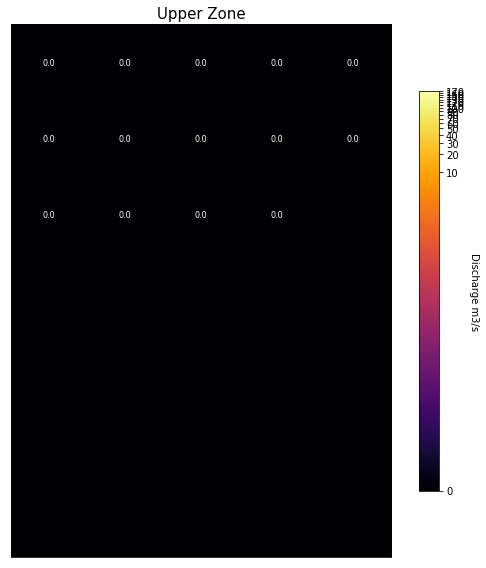

In [14]:
% matplotlib inline
from IPython.display import HTML


plotstart = "2012-07-20"
plotend = "2012-08-20"

Anim = Jiboa.plotDistributedResults(
    plotstart, plotend, Figsize=(8, 8), Option=6, threshold=160, PlotNumbers=False, TicksSpacing=10, Interval=10,
    Gauges=False, cmap='inferno', Textloc=[0.1, 0.2], Gaugecolor='red', ColorScale=2, IDcolor='blue', IDsize=25,
    gamma=0.08)

HTML(Anim.to_html5_video())

- if you like to save the animation

In [12]:
Path = SaveTo + "anim.mov"
Jiboa.saveAnimation(VideoFormat="mov", Path=Path, SaveFrames=3)

# 11-Store the result into rasters

In [13]:
StartDate = "2012-07-20"
EndDate = "2012-08-20"

Path = SaveTo + "Lumped_Parameters_" + str(dt.datetime.now())[0:10] + "_"
Jiboa.saveResults(Result=1, StartDate=StartDate, EndDate=EndDate, Path=Path, FlowAccPath=FlowAccPath)

Data is saved successfully
